## Twitter Sentiment Analysis

**Problem statement:** Airline industry had a very hard time post covid to sustain their business due to a long hault. It is very important for them to make sure they exceed customer expectations. The best way to evaluate performance is customer feedback. You are given a dataset of airline tweets from real customers.

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

You will use the text column and sentiment column to create a classification model that classifies a given tweet into one of the 3 classes - positive, negative, neutral.

**Understanding the Dataset:**

Dataset contains many columns out of which below are most important ones-
1. airline_sentiment - defines the sentiment of the tweet
2. negative_reason - reason for the negative feedback (if negative)
3. Text - tweet text content
4. tweet_location - location from which tweet was posted

You can use more columns in your model training if you want.


**Steps to perform**
1. Load dataset - https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment
2. Clean, preprocess data and EDA
3. Vectorise columns that contain text
4. Run Classification model to classify - positive, negative or neutral
5. Evaluate model



## Steps to Download kaggle datasets using Kaggle Public API

1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine.

In [1]:
!pip install -q kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thirumoorthis","key":"e832b2ba51aa8348b40960a8ca4c3c8a"}'}

In [2]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d crowdflower/twitter-airline-sentiment
! ls
! unzip twitter-airline-sentiment.zip

100% 2.55M/2.55M [00:00<00:00, 4.76MB/s]
100% 2.55M/2.55M [00:00<00:00, 4.07MB/s]
kaggle.json  sample_data  twitter-airline-sentiment.zip
Archive:  twitter-airline-sentiment.zip
  inflating: Tweets.csv              
  inflating: database.sqlite         


In [5]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import random
import re
import nltk
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

In [12]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Load tweets data

In [7]:
tweets_dataset = pd.read_csv("Tweets.csv")

In [8]:
tweets_dataset.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


In [9]:
tweets_dataset.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
tweet_id,14640.0,NaN,NaN,NaN,569218351767499200.0,779111158481835.875,567588278875213824.0,568559178101439488.0,569477857923110912.0,569890473289000960.0,570310600460525568.0
airline_sentiment,14640,3,negative,9178,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airline_sentiment_confidence,14640.0,NaN,NaN,NaN,0.900169,0.16283,0.335,0.6923,1.0,1.0,1.0
negativereason,9178,10,Customer Service Issue,2910,NaN,NaN,NaN,NaN,NaN,NaN,NaN
negativereason_confidence,10522.0,NaN,NaN,NaN,0.638298,0.33044,0.0,0.3606,0.6706,1.0,1.0
airline,14640,6,United,3822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airline_sentiment_gold,40,3,negative,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name,14640,7701,JetBlueNews,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
negativereason_gold,32,13,Customer Service Issue,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
retweet_count,14640.0,NaN,NaN,NaN,0.08265,0.745778,0.0,0.0,0.0,0.0,44.0


## Exploratory Data Analysis

### Missing value analysis

In [10]:
# Check for null values in each column

tweets_dataset.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [11]:
print("Percentage null or na values in dataset")
((tweets_dataset.isnull() | tweets_dataset.isna()).sum() * 100 / tweets_dataset.index.size).round(2)

Percentage null or na values in dataset


tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64

**airline_sentiment_gold**, **negativereason_gold** have more than 99% missing data And **tweet_coord** have nearly 93% missing data. It will be better to delete these columns as they will not provide any constructive information

## Target feature analysis

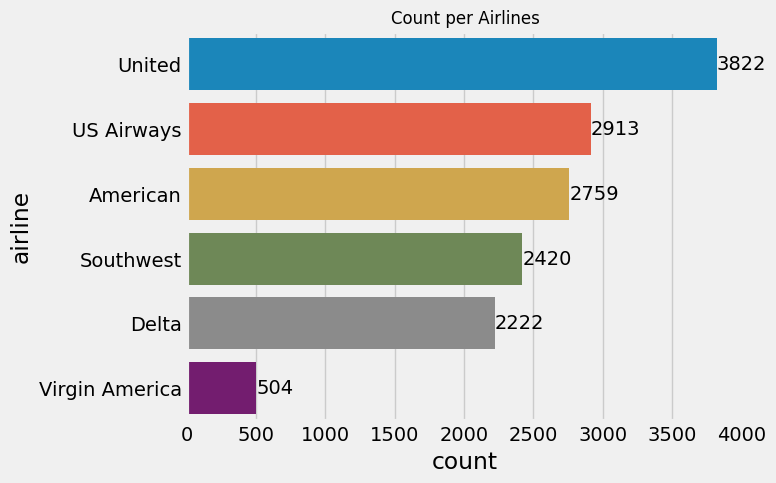

In [13]:
ax = sns.countplot(data = tweets_dataset, y = 'airline',
                   order = tweets_dataset.airline.value_counts().index)
ax.bar_label(ax.containers[0])
sns.set(rc = {'figure.figsize':(3, 3)})
ax.set_title('Count per Airlines',)
plt.show()

In [14]:
tweets_dataset.groupby(['airline', 'airline_sentiment'])['airline_sentiment'].count().unstack()

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


The airlines **United** and **US Airways** has the most negative feedbacks whereas '**SouthWest**' has most positive.

Text(0.5, 1.0, 'Count of Type of Sentiment')

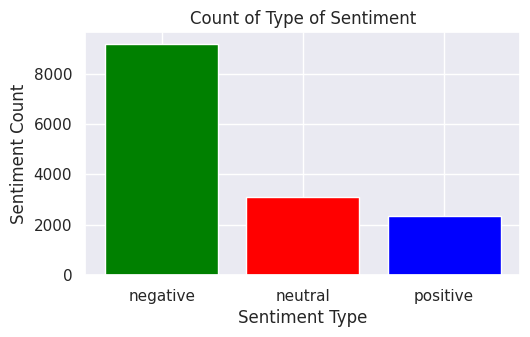

In [15]:
counter = tweets_dataset.airline_sentiment.value_counts()
index = [1,2,3]
plt.figure(1,figsize=(5,3))
plt.bar(index,counter,color=['green','red','blue'])
plt.xticks(index,['negative','neutral','positive'],rotation=0)
plt.xlabel('Sentiment Type')
plt.ylabel('Sentiment Count')
plt.title('Count of Type of Sentiment')

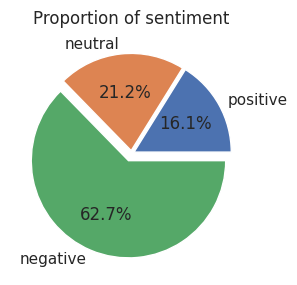

In [16]:
ax_sent = tweets_dataset.airline_sentiment.value_counts().sort_values()

plt.figure(figsize=(3, 3))
ax = plt.pie(x = ax_sent, labels=ax_sent.index, autopct = '%1.1f%%', explode = [0.03, 0.03, 0.08])
plt.title('Proportion of sentiment')

plt.show()

## Data Engineering

In [40]:
# First of all let's drop the columns which we don't required

cols_to_remove = ['tweet_id', 'airline_sentiment_confidence', 'negativereason_confidence', 'airline',
                  'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'tweet_coord', 'tweet_created',
                  'tweet_location', 'user_timezone']

tweets_data = tweets_dataset.drop(cols_to_remove, axis = 1)

In [41]:
tweets_data

,airline_sentiment,negativereason,text
0,neutral,NaN,@VirginAmerica What @dhepburn said.
1,positive,NaN,@VirginAmerica plus you've added commercials t...
2,neutral,NaN,@VirginAmerica I didn't today... Must mean I n...
3,negative,Bad Flight,@VirginAmerica it's really aggressive to blast...
4,negative,Can't Tell,@VirginAmerica and it's a really big bad thing...
...,...,...,...
14635,positive,NaN,@AmericanAir thank you we got on a different f...
14636,negative,Customer Service Issue,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,NaN,@AmericanAir Please bring American Airlines to...
14638,negative,Customer Service Issue,"@AmericanAir you have my money, you change my ..."


## Clean tweets data

In [42]:
def tweet_to_words(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet)
    words = letters_only.lower().split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    return( " ".join( meaningful_words ))

In [43]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [44]:
tweets_data['clean_tweet'] = tweets_data['text'].apply(lambda x: tweet_to_words(x))

In [45]:
tweets_data.head(5)

,airline_sentiment,negativereason,text,clean_tweet
0,neutral,NaN,@VirginAmerica What @dhepburn said.,virginamerica dhepburn said
1,positive,NaN,@VirginAmerica plus you've added commercials t...,virginamerica plus added commercials experienc...
2,neutral,NaN,@VirginAmerica I didn't today... Must mean I n...,virginamerica today must mean need take anothe...
3,negative,Bad Flight,@VirginAmerica it's really aggressive to blast...,virginamerica really aggressive blast obnoxiou...
4,negative,Can't Tell,@VirginAmerica and it's a really big bad thing...,virginamerica really big bad thing


In [46]:
le = LabelEncoder()
le.fit(tweets_data['airline_sentiment'])

tweets_data['airline_sentiment_encoded'] = le.transform(tweets_data['airline_sentiment'])

In [47]:
tweets_data.head(5)

,airline_sentiment,negativereason,text,clean_tweet,airline_sentiment_encoded
0,neutral,NaN,@VirginAmerica What @dhepburn said.,virginamerica dhepburn said,1
1,positive,NaN,@VirginAmerica plus you've added commercials t...,virginamerica plus added commercials experienc...,2
2,neutral,NaN,@VirginAmerica I didn't today... Must mean I n...,virginamerica today must mean need take anothe...,1
3,negative,Bad Flight,@VirginAmerica it's really aggressive to blast...,virginamerica really aggressive blast obnoxiou...,0
4,negative,Can't Tell,@VirginAmerica and it's a really big bad thing...,virginamerica really big bad thing,0


## Split the dataset into Train & Test

In [48]:
tweets_data.negativereason = tweets_data.negativereason.fillna('')

In [49]:
X = tweets_data['negativereason'] + ' ' + tweets_data['clean_tweet']
y = tweets_data.airline_sentiment_encoded

# print(len(x), len(y))

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Vectorization

In [51]:
vect = CountVectorizer()
vect.fit(X_train)

CountVectorizer()

In [52]:
# Use the trained to create a document-term matrix from train and test sets
x_train_dtm = vect.transform(X_train)
x_test_dtm = vect.transform(X_test)

In [53]:
X_train

750        Can't Tell united offering us rooms people fail
6875     Can't Tell jetblue jfk nyc staff amazing lax j...
7598      jetblue well last update right direction leas...
14124    Late Flight americanair flight still sitting d...
6187      southwestair companion pass broken today purc...
                               ...                        
5191      southwestair replacing vitaminwater beer brav...
13418    Customer Service Issue americanair lax service...
5390     Customer Service Issue southwestair hold hour ...
860      Customer Service Issue united would contact di...
7270      jetblue ok sure seemed like jetblue tweeted u...
Length: 11712, dtype: object

## Model Building

In [54]:
models = {
    'LR_model' : LogisticRegression(),
    'RD_model' : RidgeClassifier(),
    'DT_model' : DecisionTreeClassifier(),
    'SV_model' : SVC(),
    # 'Naive_model': GaussianNB(),
    'KNR_model' : KNeighborsClassifier(),
    'RFR_model' : RandomForestClassifier(),
    'XGB_model' : XGBClassifier(),
    'SGH_model' : SGDClassifier(),
    'Bag_model' :BaggingClassifier(),
    'ADA_model' :AdaBoostClassifier(),
    'GB_model' : GradientBoostingClassifier(),
}

In [55]:
scores_dict = {}

In [56]:
for key in models:
  print(key)
  m = models[key]
  m.fit(x_train_dtm,y_train)
  y_pred= m.predict(x_test_dtm)
  scores_dict[key] = {
        'Accuracy': round(accuracy_score(y_test, y_pred) * 100, 2)
    }

LR_model
RD_model
DT_model
SV_model
KNR_model
RFR_model
XGB_model
SGH_model
Bag_model
ADA_model
GB_model


In [57]:
scores_df = pd.DataFrame(scores_dict)
scores_df_t = scores_df.T

In [58]:
scores_df_t.sort_values(by="Accuracy", ascending=False)

,Accuracy
XGB_model,93.31
LR_model,93.10
SGH_model,93.00
SV_model,92.66
RD_model,92.21
Bag_model,91.22
GB_model,91.19
RFR_model,90.78
DT_model,89.92
ADA_model,88.08


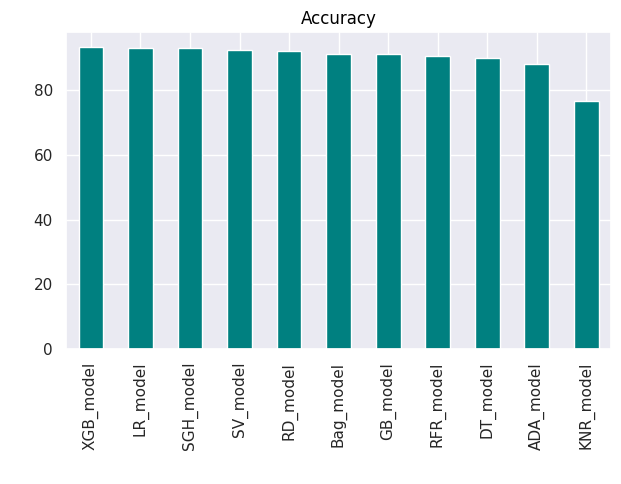

In [59]:
color_ = ['#000057', '#005757', '#005700' ,'#ad7100',  '#008080', '#575757', '#003153']
plt.figure(figsize= (12,5))
for i,col in enumerate(scores_df_t.columns):
    rand_col = color_[random.sample(range(6), 1)[0]]
    plt.subplot(1,2, i+1)

    scores_df_t[col].sort_values(ascending=False).plot(kind='bar', color=rand_col)
    plt.title(col, color = 'black')
    plt.ylabel(" ")
    plt.xlabel(" ")
    plt.tight_layout()

plt.show();

**XGBClassifier** has better accuracy **(93.31%)** than other classifiers

In [60]:
## END ##